In [1]:
%matplotlib inline
from pylab import *
import numpy.random as rnd
from functools import partial

In [5]:
# for looping over PSR
pmin1 = 0 # lower bound of parameter range
pmax1 = 100 # upper bound of parameter range
M1 = 25 # number of grid points in parameter range
paramvec1 = linspace(pmin1,pmax1,M1) # list of PSR values

# for looping over ESR
pmin2 = 0
pmax2 = 0.5
M2 = 25
paramvec2 = linspace(pmin2,pmax2,M2) # list of ESR values

m_max = zeros((M1,M2))
TTP_max = zeros((M1,M2))
TTP_mtd = zeros((M1,M2))

<b> ONLY NEED TO RUN THE FOLLOWING 4 CELLS ONCE - else, load data (csv files) for plotting </b>

In [2]:
# following values all taking from 'parameters.py' file

# pharmacodynamic parameters for dS and dR
# logistic growth rate (drug "sensitivity")
rS = 0.2 
rR = 0.2
# half-maximum point (drug "potency")
PS = 20
PR = 20 
# amplitude (drug "efficacy")
ES = 0.3
ER = 0.04
# shift constant (~ basal rate)
delS = 0.02 
delR = 0.02 

# pharmacodynamic parameters for kSR (will be looping over ESR and PSR)
rSR = 0.2 # sensitivity
kappa = 0.01 # ~ basal rate

# parameters that do not depend on drug dose
# cell division rates
bS = 0.2 
bR = 0.1 
# phenotype switching rate sentitive to resistant
kRS = 0.01 
# initial conditions
N0 = 1e9 # tumor size at detection
xi = 0.1 # fraction of resistant cells at detection
x0 = array([[(1-xi)*N0], [xi*N0]])

# set drug dose range
mvec = array(range(101))

# set range of times (for plotting trajectories)
t = linspace(0,200,num = 10000)

In [25]:
# define logistic curves
dS = lambda m: delS + ES/(1+exp(-rS*(m-PS))) # sens death rate
dR = lambda m: delR + ER/(1+exp(-rR*(m-PR))) # res death rate
kSR = lambda m, eSR, pSR: kappa + eSR/(1+exp(-rSR*(m-pSR))) # transition S->R

# define net growth rates
gS = lambda m: bS - dS(m)
gR = lambda m: bR - dR(m)

# miscellaneous constants & eigenvalues/vectors
alpha = lambda m,eSR,pSR: gR(m)-gS(m)+kSR(m,eSR,pSR)-kRS
mybeta = lambda m,eSR,pSR: sqrt(alpha(m,eSR,pSR)**2 + 4*kSR(m,eSR,pSR)*kRS)
lam1 = lambda m,eSR,pSR: 0.5*(gS(m)+gR(m)-kSR(m,eSR,pSR)-kRS+mybeta(m,eSR,pSR))
lam2 = lambda m,eSR,pSR: 0.5*(gS(m)+gR(m)-kSR(m,eSR,pSR)-kRS-mybeta(m,eSR,pSR))
vec1 = lambda m,eSR,pSR: (-alpha(m,eSR,pSR)+mybeta(m,eSR,pSR))/(2*kSR(m,eSR,pSR))
vec2 = lambda m,eSR,pSR: (-alpha(m,eSR,pSR)-mybeta(m,eSR,pSR))/(2*kSR(m,eSR,pSR))

In [26]:
# function that computes TTP(m) using exact solution of ODE for ESR=eSR and PSR=pSR
def TTP_fun(m,eSR,pSR):
    V = [[vec1(m,eSR,pSR), vec2(m,eSR,pSR)],[1,1]] # eigenvalues
    c = inv(V).dot(x0) # constants in exact solution
    t = linspace(0,200,num = 10000)
    xtrue = zeros((2,len(t))) # exact solution to ODE
    for j in range(1,len(t)):
        if c[0]*exp(lam1(m,eSR,pSR)*t[j])*(vec1(m,eSR,pSR)+1) + c[1]*exp(lam2(m,eSR,pSR)*t[j])*(vec2(m,eSR,pSR)+1) > x0[0]+x0[1]:
            break
    return t[j]

In [27]:
# note to self - should parallelize these for loops to make code run faster
for ii in range(M1):
    for jj in range(M2):
        PSR = paramvec1[ii]
        ESR = paramvec2[jj]
        
        TTP_map = partial(TTP_fun,eSR=ESR,pSR=PSR)
        TTP = array(list(map(TTP_map, range(101)))) # parallelized computation of TTP
        
        TTP_max[ii,jj] = np.max(TTP) # maximum value of TTP over drug dose m
        TTP_mtd[ii,jj] = TTP[-1] # TTP at MTD (m=100)
        
        if np.max(TTP) == TTP[-1]: # if max value = saturation value, set argmax to MTD (monotone TTP)
            m_max[ii,jj] = int(100)
        else:
            m_max[ii,jj] = np.argmax(TTP)

np.savetxt('data/PSR_ESR_mmax.csv',m_max,delimiter=",")
np.savetxt('data/PSR_ESR_TTPmax.csv',TTP_max,delimiter=",")
np.savetxt('data/PSR_ESR_TTPmtd.csv',TTP_mtd,delimiter=",")

<b> Start with this cell if the above cells have already been run (i.e. the data have been generated): </b>

In [10]:
# load csv files for plotting
m_max = np.loadtxt('data/PSR_ESR_mmax.csv',delimiter=",")
TTP_max = np.loadtxt('data/PSR_ESR_TTPmax.csv',delimiter=",")
TTP_mtd = np.loadtxt('data/PSR_ESR_TTPmtd.csv',delimiter=",")

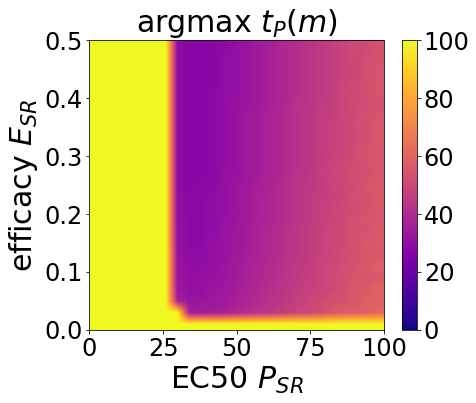

In [11]:
figure(figsize=(7,6))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)

plt.imshow(np.flip(m_max.T,axis=0),cmap="plasma",vmin=0, vmax=100,interpolation='bilinear',extent=[pmin1,pmax1,pmin2,pmax2],aspect='auto')
plt.colorbar()
plt.xlabel(r"EC50 $P_{SR}$")
plt.ylabel(r"efficacy $E_{SR}$")
plt.title(r"argmax $t_P(m)$")
plt.tight_layout()

plt.savefig('../manuscript/figures/individual/PSR_ESR_mmax.svg')
plt.savefig('../manuscript/figures/individual/PSR_ESR_mmax.png',dpi=300)

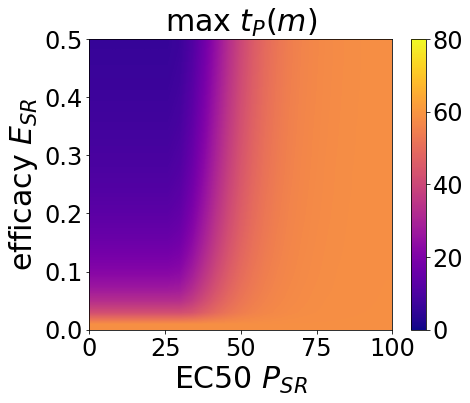

In [20]:
figure(figsize=(7,6))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)

plt.imshow(np.flip(TTP_max.T,axis=0),cmap="plasma",vmin=0, vmax=80,interpolation='bilinear',extent=[pmin1,pmax1,pmin2,pmax2],aspect='auto')
plt.colorbar()
plt.xlabel(r"EC50 $P_{SR}$")
plt.ylabel(r"efficacy $E_{SR}$")
plt.title(r"max $t_P(m)$")
plt.tight_layout()

plt.savefig('../manuscript/figures/individual/PSR_ESR_TTPmax.svg')
plt.savefig('../manuscript/figures/individual/PSR_ESR_TTPmax.png',dpi=300)

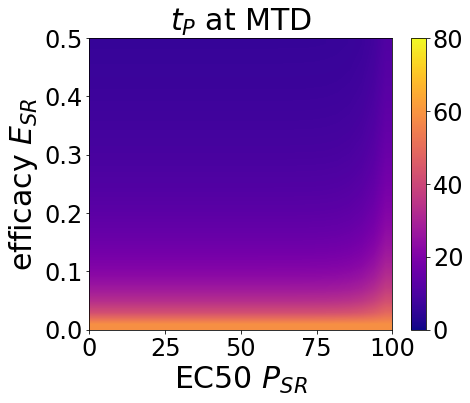

In [18]:
figure(figsize=(7,6))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)

plt.imshow(np.flip(TTP_mtd.T,axis=0),cmap="plasma",vmin=0, vmax=80,interpolation='bilinear',extent=[pmin1,pmax1,pmin2,pmax2],aspect='auto')
plt.colorbar()
plt.xlabel(r"EC50 $P_{SR}$")
plt.ylabel(r"efficacy $E_{SR}$")
plt.title(r"$t_P$ at MTD")
plt.tight_layout()

plt.savefig('../manuscript/figures/individual/PSR_ESR_TTPmtd.svg')
plt.savefig('../manuscript/figures/individual/PSR_ESR_TTPmtd.png',dpi=300)